In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
from pipelines import *

from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from prettytable import PrettyTable


In [2]:
path = '/Users/tristangarcia/Desktop/hp-pred/data/'

train = pd.read_csv(f'{path}wa_train.csv')
test = pd.read_csv(f'{path}wa_test.csv')

with open(f'{path}preprocessing_pipeline.pkl', 'rb') as f:
    pipeline = pickle.load(f)

with open(f'{path}randomforest.pkl', 'rb') as f:
    rf_model = pickle.load(f)
    
with open(f'{path}xgboost.pkl', 'rb') as f:
    xgb_model = pickle.load(f)

In [3]:
train = pipeline.transform(train)
test = pipeline.transform(test)

### Split

In [4]:
x_train = train.drop(columns=['soldPrice'])
y_train = train['soldPrice']

x_test = test.drop(columns=['soldPrice'])
y_test = test['soldPrice']

# Utility Functions

In [5]:
def calculate_regression_metrics(y_true, y_pred):
    """
    Calculate regression metrics: MSE, RMSE, MAE, MAPE, and R-squared.
    """
    mse = round(mean_squared_error(y_true, y_pred), 4)
    rmse = round(np.sqrt(mse), 4)  # Calculate RMSE
    mae = round(mean_absolute_error(y_true, y_pred), 4)
    mape = round(np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100, 4)  # Avoid division by zero
    r2 = round(r2_score(y_true, y_pred), 4)
    return mse, rmse, mae, mape, r2

def print_regression_results_table(train_results, test_results, model_name):
    """
    Print regression results in a PrettyTable for train and test datasets.
    """
    table = PrettyTable()
    table.field_names = ['Dataset', 'Model', 'MSE', 'RMSE', 'MAE', 'MAPE', 'R2']
    
    # Unpack train and test results
    train_mse, train_rmse, train_mae, train_mape, train_r2 = train_results
    test_mse, test_rmse, test_mae, test_mape, test_r2 = test_results
    
    table.add_row(['Train', model_name, train_mse, train_rmse, train_mae, train_mape, train_r2])
    table.add_row(['Test', model_name, test_mse, test_rmse, test_mae, test_mape, test_r2])
    print(table)

def plot_predictions(y_true_train, y_pred_train, y_true_test, y_pred_test):
    """
    Plot predictions vs. actual values for train and test datasets.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
    sns.scatterplot(x=y_true_train, y=y_pred_train, ax=axes[0], color="blue", alpha=0.7)
    axes[0].plot([min(y_true_train), max(y_true_train)], [min(y_true_train), max(y_true_train)], 'r--')
    axes[0].set_title("Train: Actual vs. Predicted")
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predicted")
    
    sns.scatterplot(x=y_true_test, y=y_pred_test, ax=axes[1], color="green", alpha=0.7)
    axes[1].plot([min(y_true_test), max(y_true_test)], [min(y_true_test), max(y_true_test)], 'r--')
    axes[1].set_title("Test: Actual vs. Predicted")
    axes[1].set_xlabel("Actual")
    
    plt.tight_layout()
    plt.show()

def evaluate_model(model, x_train, y_train, x_test, y_test, model_name):
    """ 
    Evaluate regression model performance on train and test datasets.
    """
    # Train the model
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    # Calculate metrics for train set
    train_results = calculate_regression_metrics(y_train, y_train_pred)
    
    # Calculate metrics for test set
    test_results = calculate_regression_metrics(y_test, y_test_pred)
    
    # Print results in a table
    print_regression_results_table(train_results, test_results, model_name)
    
    # Plot predictions vs. actual
    plot_predictions(y_train, y_train_pred, y_test, y_test_pred)
    
    return model

# Evaluation

### Random Forest

+---------+---------------+-------+--------+--------+--------+--------+
| Dataset |     Model     |  MSE  |  RMSE  |  MAE   |  MAPE  |   R2   |
+---------+---------------+-------+--------+--------+--------+--------+
|  Train  | Random Forest | 0.001 | 0.0316 | 0.0229 | 0.3912 | 0.9809 |
|   Test  | Random Forest | 0.007 | 0.0837 | 0.0605 | 1.0342 | 0.8685 |
+---------+---------------+-------+--------+--------+--------+--------+


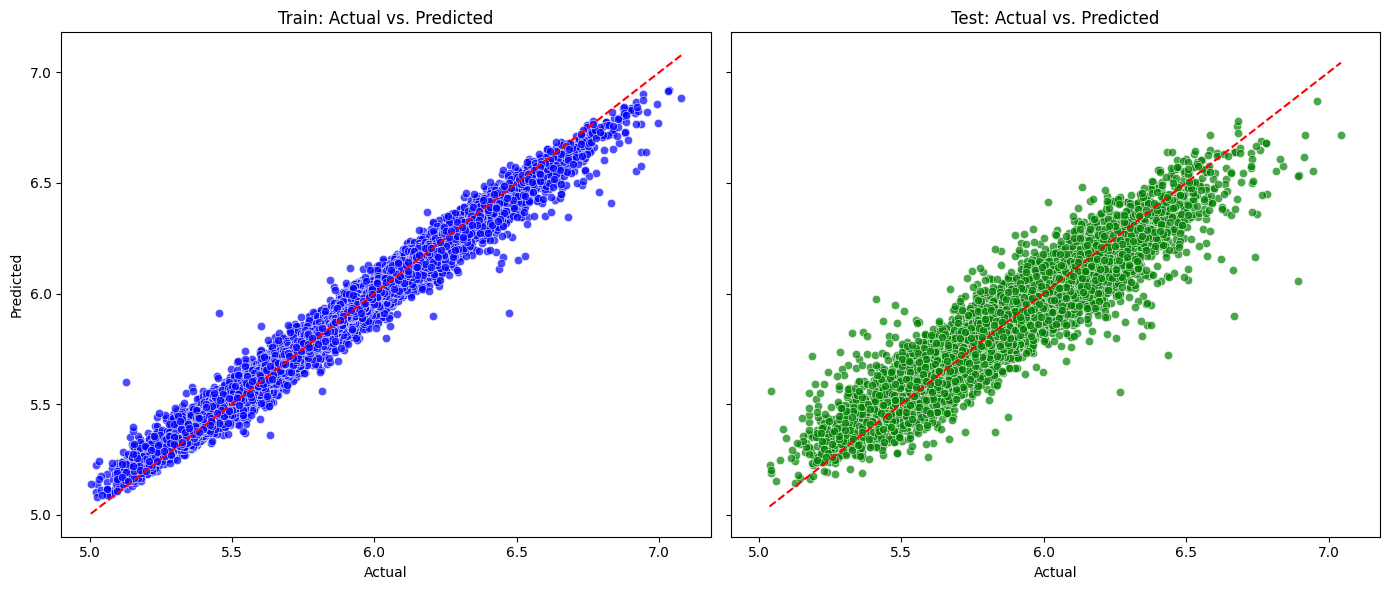

RandomForestRegressor(max_features=0.5, n_estimators=400)

In [6]:
evaluate_model(rf_model, x_train, y_train, x_test, y_test, 'Random Forest')

### XGBoost

+---------+---------+--------+--------+--------+--------+--------+
| Dataset |  Model  |  MSE   |  RMSE  |  MAE   |  MAPE  |   R2   |
+---------+---------+--------+--------+--------+--------+--------+
|  Train  | XGBoost | 0.003  | 0.0548 | 0.0413 | 0.7081 | 0.9441 |
|   Test  | XGBoost | 0.0068 | 0.0825 | 0.0608 | 1.0404 | 0.8718 |
+---------+---------+--------+--------+--------+--------+--------+


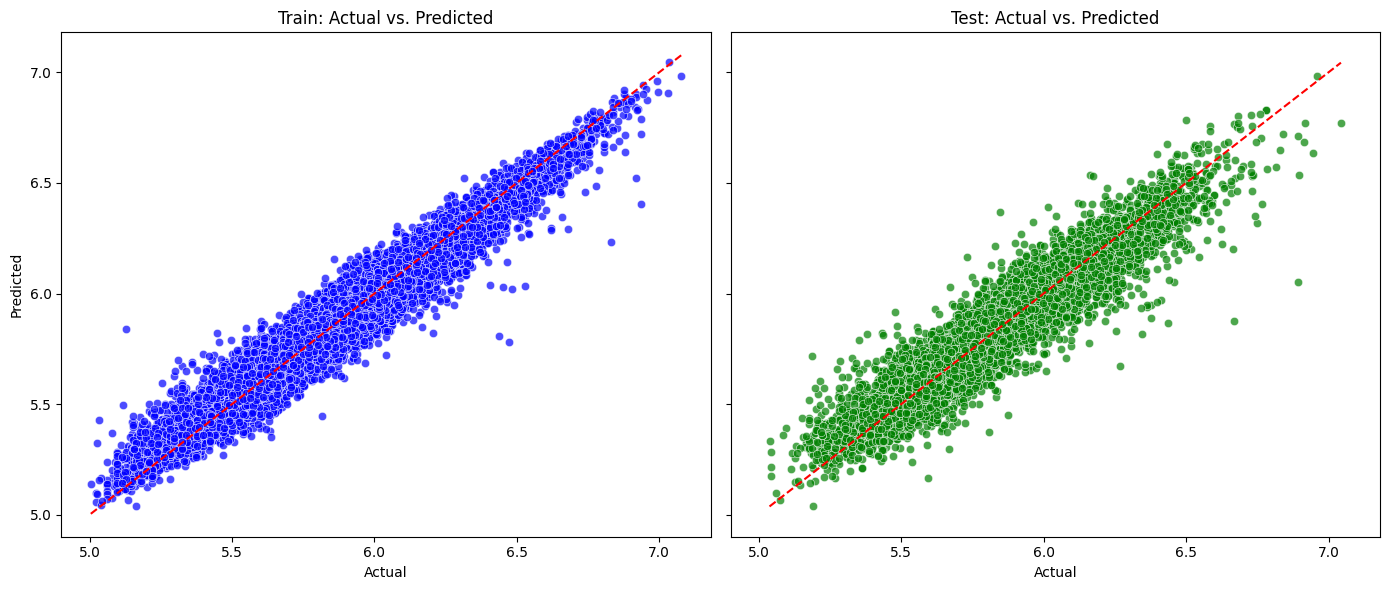

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [7]:
evaluate_model(xgb_model, x_train, y_train, x_test, y_test, 'XGBoost')